In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from web3 import Web3
from inspect import signature  # Instead of getargspec
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
# Connect to Ethereum Node
import json
w3 = Web3(Web3.HTTPProvider("http://127.0.0.1:7545"))  
contract_address = "0x9DeAEdafa773AA456307e8b91Be3D0b4FbE5fca2"
abi = json.loads("""
[
    {
        "inputs": [],
        "stateMutability": "nonpayable",
        "type": "constructor"
    },
    {
        "anonymous": false,
        "inputs": [
            {
                "indexed": false,
                "internalType": "enum AdaptiveConsensus.ConsensusType",
                "name": "newConsensus",
                "type": "uint8"
            }
        ],
        "name": "ConsensusChanged",
        "type": "event"
    },
    {
        "inputs": [
            {
                "internalType": "enum AdaptiveConsensus.ConsensusType",
                "name": "_newConsensus",
                "type": "uint8"
            }
        ],
        "name": "switchConsensus",
        "outputs": [],
        "stateMutability": "nonpayable",
        "type": "function"
    },
    {
        "inputs": [],
        "name": "currentConsensus",
        "outputs": [
            {
                "internalType": "enum AdaptiveConsensus.ConsensusType",
                "name": "",
                "type": "uint8"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    }
]
""") 
contract = w3.eth.contract(address=contract_address, abi=abi)


In [5]:
df=pd.read_csv(r"C:\Users\91727\Desktop\ETC Block info.csv")
df.head(5)
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               1000 non-null   object 
 1   number                  1000 non-null   int64  
 2   hash                    1000 non-null   object 
 3   parent_hash             1000 non-null   object 
 4   nonce                   1000 non-null   object 
 5   sha3_uncles             1000 non-null   object 
 6   logs_bloom              1000 non-null   object 
 7   transactions_root       1000 non-null   object 
 8   state_root              1000 non-null   object 
 9   receipts_root           1000 non-null   object 
 10  miner                   1000 non-null   object 
 11  difficulty              1000 non-null   float64
 12  total_difficulty        1000 non-null   float64
 13  size                    1000 non-null   int64  
 14  extra_data              1000 non-null   o

(1000, 19)

In [7]:
df.isnull().sum()

timestamp                 0
number                    0
hash                      0
parent_hash               0
nonce                     0
sha3_uncles               0
logs_bloom                0
transactions_root         0
state_root                0
receipts_root             0
miner                     0
difficulty                0
total_difficulty          0
size                      0
extra_data                0
gas_limit                 0
gas_used                  0
transaction_count         0
hash_rate_distribution    0
dtype: int64

In [9]:
df.describe()

,number,difficulty,total_difficulty,size,gas_limit,gas_used,transaction_count,hash_rate_distribution
count,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000
mean,1.166073e+07,4.627142e+13,1.040540e+21,922.222000,8.013603e+06,7.404648e+04,3.139000,0.138302
std,2.888194e+02,4.433162e+11,1.356271e+16,887.972276,1.836290e+04,1.998067e+05,7.539531,0.108250
min,1.166024e+07,4.520000e+13,1.040520e+21,524.000000,7.986427e+06,0.000000e+00,0.000000,0.001000
25%,1.166048e+07,4.595980e+13,1.040530e+21,529.000000,8.000000e+06,0.000000e+00,0.000000,0.070000
50%,1.166073e+07,4.618640e+13,1.040540e+21,543.000000,8.007804e+06,0.000000e+00,0.000000,0.092000
75%,1.166098e+07,4.666550e+13,1.040550e+21,882.000000,8.023268e+06,6.300000e+04,2.000000,0.293000
max,1.166123e+07,4.705520e+13,1.040560e+21,9927.000000,8.094207e+06,3.589024e+06,82.000000,0.293000


In [11]:
df['timestamp'] = pd.to_datetime(df['timestamp'])  #converting UNIX to date-time 
print(df[['timestamp']].head())

                  timestamp
0 2020-11-22 23:59:45+00:00
1 2020-11-22 23:59:37+00:00
2 2020-11-22 23:59:23+00:00
3 2020-11-22 23:59:16+00:00
4 2020-11-22 23:59:13+00:00


In [13]:
df['miner_blocks'] = df.groupby('miner')['number'].transform('count')
df['hash_rate_distribution'] = df['miner_blocks'] / len(df)
df.drop(columns=['miner_blocks'], inplace=True)
print(df[['miner', 'hash_rate_distribution']].head(10))

                                        miner  hash_rate_distribution
0  0x35aa26bbfe74714b38ef668e36f986daac80846a                   0.155
1  0x0992f223b1d94403c4055c7ec2c6a8c648d49a11                   0.021
2  0xf35074bbd0a9aee46f4ea137971feec024ab704e                   0.071
3  0xdf7d7e053933b5cc24372f878c90e62dadad5d42                   0.293
4  0xa6e43e5d497ce1f4d28b4270630e97308eda8b3e                   0.092
5  0x0992f223b1d94403c4055c7ec2c6a8c648d49a11                   0.021
6  0xdf7d7e053933b5cc24372f878c90e62dadad5d42                   0.293
7  0xdf7d7e053933b5cc24372f878c90e62dadad5d42                   0.293
8  0x0239da7f7d5af4cff574c507bb6ce18ddc73b875                   0.006
9  0x9eab4b0fc468a7f5d46228bf5a76cb52370d068d                   0.070


In [15]:
selected_features = ['difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used', 'transaction_count']
df_selected = df[selected_features].dropna() 

In [91]:
scaler=RobustScaler()
df_scaled = scaler.fit_transform(df_selected)

# Isolation forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(df_scaled)  # -1 = Anomaly, 1 = Normal
anomalies = df[df['Anomaly'] == -1]
num_anomalies = len(anomalies)
print(f"Total anomalies detected: {num_anomalies}")
print(anomalies[['timestamp', 'number', 'difficulty', 'gas_used', 'transaction_count', 'Anomaly']].head())

Total anomalies detected: 50
                   timestamp    number    difficulty  gas_used  \
16 2020-11-22 23:56:48+00:00  11661218  4.524410e+13    462000   
46 2020-11-22 23:48:04+00:00  11661188  4.555500e+13    420000   
69 2020-11-22 23:41:13+00:00  11661165  4.584580e+13    126000   
72 2020-11-22 23:40:47+00:00  11661162  4.580100e+13    252000   
78 2020-11-22 23:39:21+00:00  11661156  4.582340e+13    333224   

    transaction_count  Anomaly  
16                 22       -1  
46                 20       -1  
69                  6       -1  
72                 12       -1  
78                 10       -1  


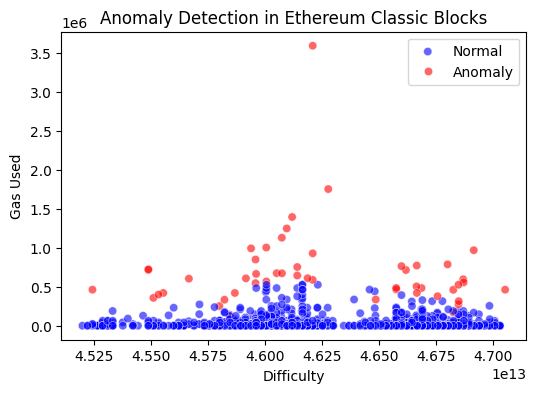

In [93]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='difficulty', y='gas_used', hue='Anomaly', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title("Anomaly Detection in Ethereum Classic Blocks")
plt.xlabel("Difficulty")
plt.ylabel("Gas Used")
plt.legend(["Normal", "Anomaly"])
plt.show()

In [97]:
DIFFICULTY_THRESHOLD = df['difficulty'].quantile(0.95)  # Lowered to 90th percentile
GAS_USED_THRESHOLD = df['gas_used'].quantile(0.95)  # Lowered to 90th percentile
TRANSACTION_COUNT_THRESHOLD = df['transaction_count'].quantile(0.90)  # Lowered to 80th percentile

def classify_anomaly(row):
    # Major Anomalies (51% Attack, Extreme Gas Usage)
    if row['difficulty'] > DIFFICULTY_THRESHOLD:
        return "Major", "51% Attack"  # Assign Major + Attack Type
    elif row['gas_used'] > GAS_USED_THRESHOLD:
        return "Major", "Sybil Attack"

    # Minor Anomalies (Spam, Sybil Attack, Medium Traffic)
    elif row['transaction_count'] > TRANSACTION_COUNT_THRESHOLD:
        return "Minor", "Spam Attack"

    # Normal Blockchain Activity
    else:
        return "Normal", "None"

# Print thresholds for reference
print("95th Percentile Difficulty:", DIFFICULTY_THRESHOLD)
print("95th Percentile Gas Used:", GAS_USED_THRESHOLD)
print("90th Percentile Transaction Count:", TRANSACTION_COUNT_THRESHOLD)

# Apply Classification to Each Row
df[['Anomaly_Type', 'Attack_Type']] = df.apply(classify_anomaly, axis=1, result_type='expand')

# Check output
print(df[['Anomaly_Type', 'Attack_Type']].head())


95th Percentile Difficulty: 46894200000000.0
95th Percentile Gas Used: 431705.19999999955
90th Percentile Transaction Count: 9.0
  Anomaly_Type Attack_Type
0       Normal        None
1       Normal        None
2       Normal        None
3       Normal        None
4       Normal        None


In [99]:
# Securely Load Private Key (Avoid Hardcoding)
PRIVATE_KEY = "0xdcb30a222962b686e581568e24960c3bab3d891391f02142ba95377d92123c87"
ACCOUNT_ADDRESS = w3.eth.account.from_key(PRIVATE_KEY).address

def switch_consensus(new_consensus):
    try:
        nonce = w3.eth.get_transaction_count(ACCOUNT_ADDRESS)

        tx = contract.functions.switchConsensus(new_consensus).build_transaction({
            'from': ACCOUNT_ADDRESS,
            'gas': 2000000,
            'gasPrice': w3.to_wei(5, 'gwei'),  # Ensure it's an integer
            'nonce': nonce
        })

        signed_tx = w3.eth.account.sign_transaction(tx, private_key=PRIVATE_KEY)
        tx_hash = w3.eth.send_raw_transaction(signed_tx["raw_transaction"])

        print(f"✅ Consensus Switched! Tx Hash: {tx_hash.hex()}")
    
    except Exception as e:
        print(f"❌ Error sending transaction: {str(e)}")


In [102]:
for index, row in df.iterrows():
    anomaly_type = row['Anomaly_Type']

    if anomaly_type == "Major":
        print("🚨 51% Attack Detected! Changing Consensus...")

        # Choose consensus based on severity and network conditions
        if row["Attack_Type"] == "51% Attack":
            switch_consensus(5)  # Proof of Authority (PoA) for strict security
        elif row["Attack_Type"] == "Sybil Attack":
            switch_consensus(4)  # PBFT handles spam and Sybil attacks well
        elif row["Attack_Type"] == "Scalability Issue":
            switch_consensus(3)  # DPoS improves scalability
        else:
            switch_consensus(1)  # Default fallback to PoS

    elif anomaly_type == "Minor":
        print("⚙️ Spam or Sybil Attack Detected! Adjusting Network Fees...")

        # Adjusting gas fees rather than full consensus change
        if row["Attack_Type"] == "Spam Attack":
            switch_consensus(4)  # PBFT can handle spam effectively
        else:
            print("✅ Minor issue detected, but no consensus change needed.")

    else:
        print("✅ Network is stable. No consensus change needed.")


✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
✅ Network is stable. No consensus change needed.
🚨 51% Attack Detected! Changing Consensus...
✅ Consensus Switched! Tx Hash: ad2f9c5756041f5199443d1a62ae3c329c3566fb8cbdf4c00a2125007b448bb5
✅ Network is stable. No consensus change needed.
✅ Network is stable. No co

In [104]:
# Evaluate Accuracy
y_true = (df['Anomaly_Type'] != "Normal").astype(int)
y_pred = (df['Anomaly'] == -1).astype(int)
print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
print(f"Precision: {precision_score(y_true, y_pred):.2f}")
print(f"Recall: {recall_score(y_true, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")

Accuracy: 0.91
Precision: 0.96
Recall: 0.35
F1 Score: 0.51
